<a href="https://colab.research.google.com/github/SamikshKodgire/AAI521_SmartVisionAgri/blob/main/AAI_521_SKodgire_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 SmartVisionAgri: Plant Leaf Disease Classification using Deep Learning

### AAI-521: Computer Vision Applications  
**Author:** Samiksha Kodgire  


---

##  Overview
This project aims to develop an automated system to detect and classify plant leaf diseases using deep learning techniques.  
By leveraging Convolutional Neural Networks (CNN) and Transfer Learning, this model supports early detection of plant diseases, potentially improving agricultural productivity and reducing manual inspection efforts.

---

##  Objectives
1. Detect whether a plant leaf is **healthy or diseased**.  
2. Classify the **type of disease** using image classification models.  
3. Compare **baseline CNN** and **transfer learning models (ResNet50, MobileNetV2)**.  
4. Use **Grad-CAM** to visualize model interpretability.  

---


In [13]:
# ==============================================================
# 0. Environment: imports and reproducibility
# ==============================================================

import os, shutil, math, random, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
from pathlib import Path

import seaborn as sns
import cv2

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# High-level libs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0



# 2. Dataset Loading and Directory Setup

I have used the **PlantVillage Dataset**, available on [Kaggle](https://www.kaggle.com/datasets/emmarex/plantdisease).  
After downloading, upload the dataset folder to your Google Drive and mount it here.


In [3]:
# ==============================================================
# 1. Mount Google Drive
# ==============================================================

from google.colab import drive
drive.mount('/content/drive')

print("Drive mounted successfully!")


Mounted at /content/drive
Drive mounted successfully!


In [5]:
DRIVE_DATASET_FOLDER = "/content/drive/MyDrive/FinalProject_AAI521/PlantVillage"  # <-- CHANGE if needed
RUNTIME_ORIG = "/content/PlantVillage_original"

import shutil
import os

if not os.path.exists(RUNTIME_ORIG):
    print("Copying dataset from Drive to runtime...")
    shutil.copytree(DRIVE_DATASET_FOLDER, RUNTIME_ORIG)
    print("Copy complete.")
else:
    print("Original dataset already copied in runtime:", RUNTIME_ORIG)

# Show directories
print("\nTop-level directories inside original dataset:")
for item in sorted(os.listdir(RUNTIME_ORIG))[:15]:
    print(" -", item)


Copying dataset from Drive to runtime...
Copy complete.

Top-level directories inside original dataset:
 - .DS_Store
 - Pepper__bell___Bacterial_spot
 - Pepper__bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Tomato_Bacterial_spot
 - Tomato_Early_blight
 - Tomato_Late_blight
 - Tomato_Leaf_Mold
 - Tomato_Septoria_leaf_spot
 - Tomato_Spider_mites_Two_spotted_spider_mite
 - Tomato__Target_Spot
 - Tomato__Tomato_YellowLeaf__Curl_Virus
 - Tomato__Tomato_mosaic_virus


#
# 2. SAFE STRATIFIED SAMPLING (NO DELETION)
#

We create:

📁 `/content/PlantVillage_original` – safe  
📁 `/content/PlantVillage_working` – working copy used for training  

We **copy**, not delete.  


In [7]:
# Parameters
WORKING_DIR = "/content/PlantVillage_working"
MAX_IMAGES_PER_CLASS = 500         # Adjust for speed
IMG_SIZE = (128, 128)              # Resize target
BATCH_SIZE = 16
EPOCHS = 20
FORCE_RECREATE = True

# Helper to clean working dir
def ensure_empty_dir(path):
    if os.path.exists(path) and FORCE_RECREATE:
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

ensure_empty_dir(WORKING_DIR)

# Collect class folders
class_folders = sorted([d for d in os.listdir(RUNTIME_ORIG) if os.path.isdir(os.path.join(RUNTIME_ORIG, d))])
print("Detected classes:", len(class_folders))

image_exts = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']

# Copy sampled images
for cls in class_folders:
    src_dir = os.path.join(RUNTIME_ORIG, cls)
    dst_dir = os.path.join(WORKING_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)

    images = []
    for ext in image_exts:
        images.extend(glob.glob(os.path.join(src_dir, ext)))

    random.shuffle(images)
    selected = images[:MAX_IMAGES_PER_CLASS]

    for file in selected:
        shutil.copy2(file, dst_dir)

print("\nWorking dataset created at:", WORKING_DIR)


Detected classes: 15

Working dataset created at: /content/PlantVillage_working



##  3. RESIZE ALL IMAGES TO 128×128




In [8]:
def resize_all(path, size=(128,128)):
    failures = 0
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    failures += 1
                    continue
                img = cv2.resize(img, size)
                cv2.imwrite(img_path, img)
            except:
                failures += 1
    return failures

print("Resizing images to 128×128...")
fails = resize_all(WORKING_DIR)
print("Resize failures:", fails)


Resizing images to 128×128...
Resize failures: 7025


## 4. EDA on Working Dataset

We'll visualize sample images from the dataset, check the number of classes, and understand class distribution.

In [11]:
# Count images per class
counts = {cls: len(os.listdir(os.path.join(WORKING_DIR, cls))) for cls in class_folders}
df_counts = pd.DataFrame(counts.items(), columns=["Class", "Count"]).sort_values("Count", ascending=False)
df_counts


,Class,Count
0,Pepper__bell___Bacterial_spot,500
1,Pepper__bell___healthy,500
2,Potato___Early_blight,500
3,Potato___Late_blight,500
5,Tomato_Bacterial_spot,500
6,Tomato_Early_blight,500
7,Tomato_Late_blight,500
11,Tomato__Target_Spot,500
8,Tomato_Leaf_Mold,500
9,Tomato_Septoria_leaf_spot,500


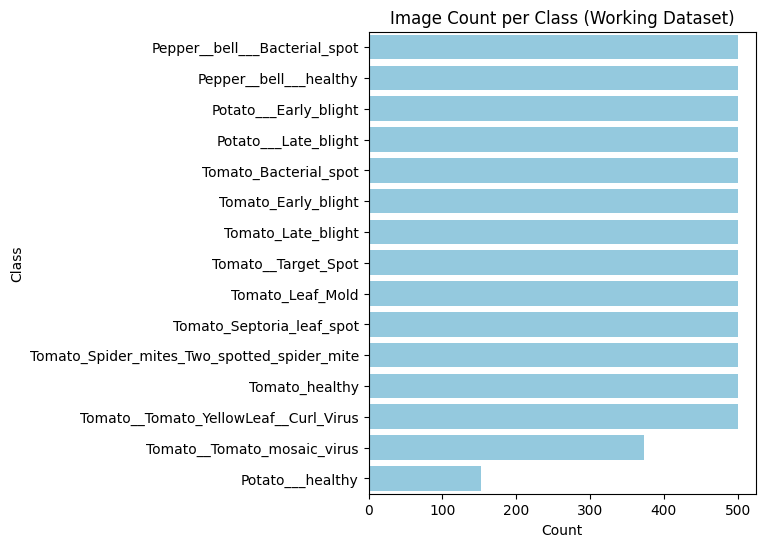

In [20]:
plt.figure(figsize=(5,6))
sns.barplot(data=df_counts, x="Count", y="Class", color="skyblue")
plt.title("Image Count per Class (Working Dataset)")
plt.show()


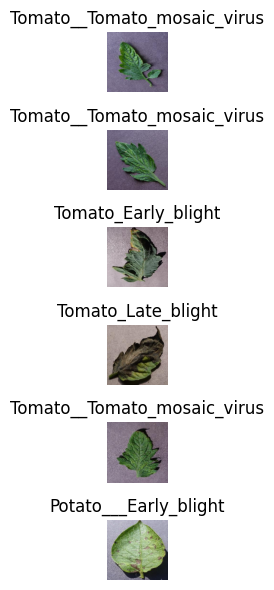

In [23]:
# Show random samples
plt.figure(figsize=(12,6))
for i in range(6):
    cls = random.choice(class_folders)
    img_path = random.choice(glob.glob(os.path.join(WORKING_DIR, cls, "*")))
    img = plt.imread(img_path)
    plt.subplot(6,1,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [27]:
# ============================================
# 📊 Summary Statistics
# ============================================

print("Total Classes:", len(class_folders))
print("Total Images in Working Dataset:", df_counts["Count"].sum())

print("\nTop 5 Largest Classes:")
display(df_counts.sort_values("Count", ascending=False).head(5))

print("\nTop 5 Smallest Classes:")
display(df_counts.sort_values("Count", ascending=True).head(5))


Total Classes: 15
Total Images in Working Dataset: 7025

Top 5 Largest Classes:


,Class,Count
0,Pepper__bell___Bacterial_spot,500
1,Pepper__bell___healthy,500
2,Potato___Early_blight,500
3,Potato___Late_blight,500
5,Tomato_Bacterial_spot,500



Top 5 Smallest Classes:


,Class,Count
4,Potato___healthy,152
13,Tomato__Tomato_mosaic_virus,373
0,Pepper__bell___Bacterial_spot,500
1,Pepper__bell___healthy,500
5,Tomato_Bacterial_spot,500


##  Original vs Working Dataset Distribution

To evaluate the impact of stratified sampling, it is important to compare the class distribution of the **original PlantVillage dataset** with the **working dataset** used for model training.

This visualization helps demonstrate:

- The original dataset is highly imbalanced with thousands of samples per class.  
- The working dataset applies a **max cap (e.g., 300 images per class)** for computational feasibility.  
- Sampling reduces redundancy and ensures balanced training while preserving class representation.  
- The plot shows a clear side-by-side comparison of both distributions.

The resulting figure is useful for both the final report and the video presentation, demonstrating thoughtful data preprocessing and resource-aware design.


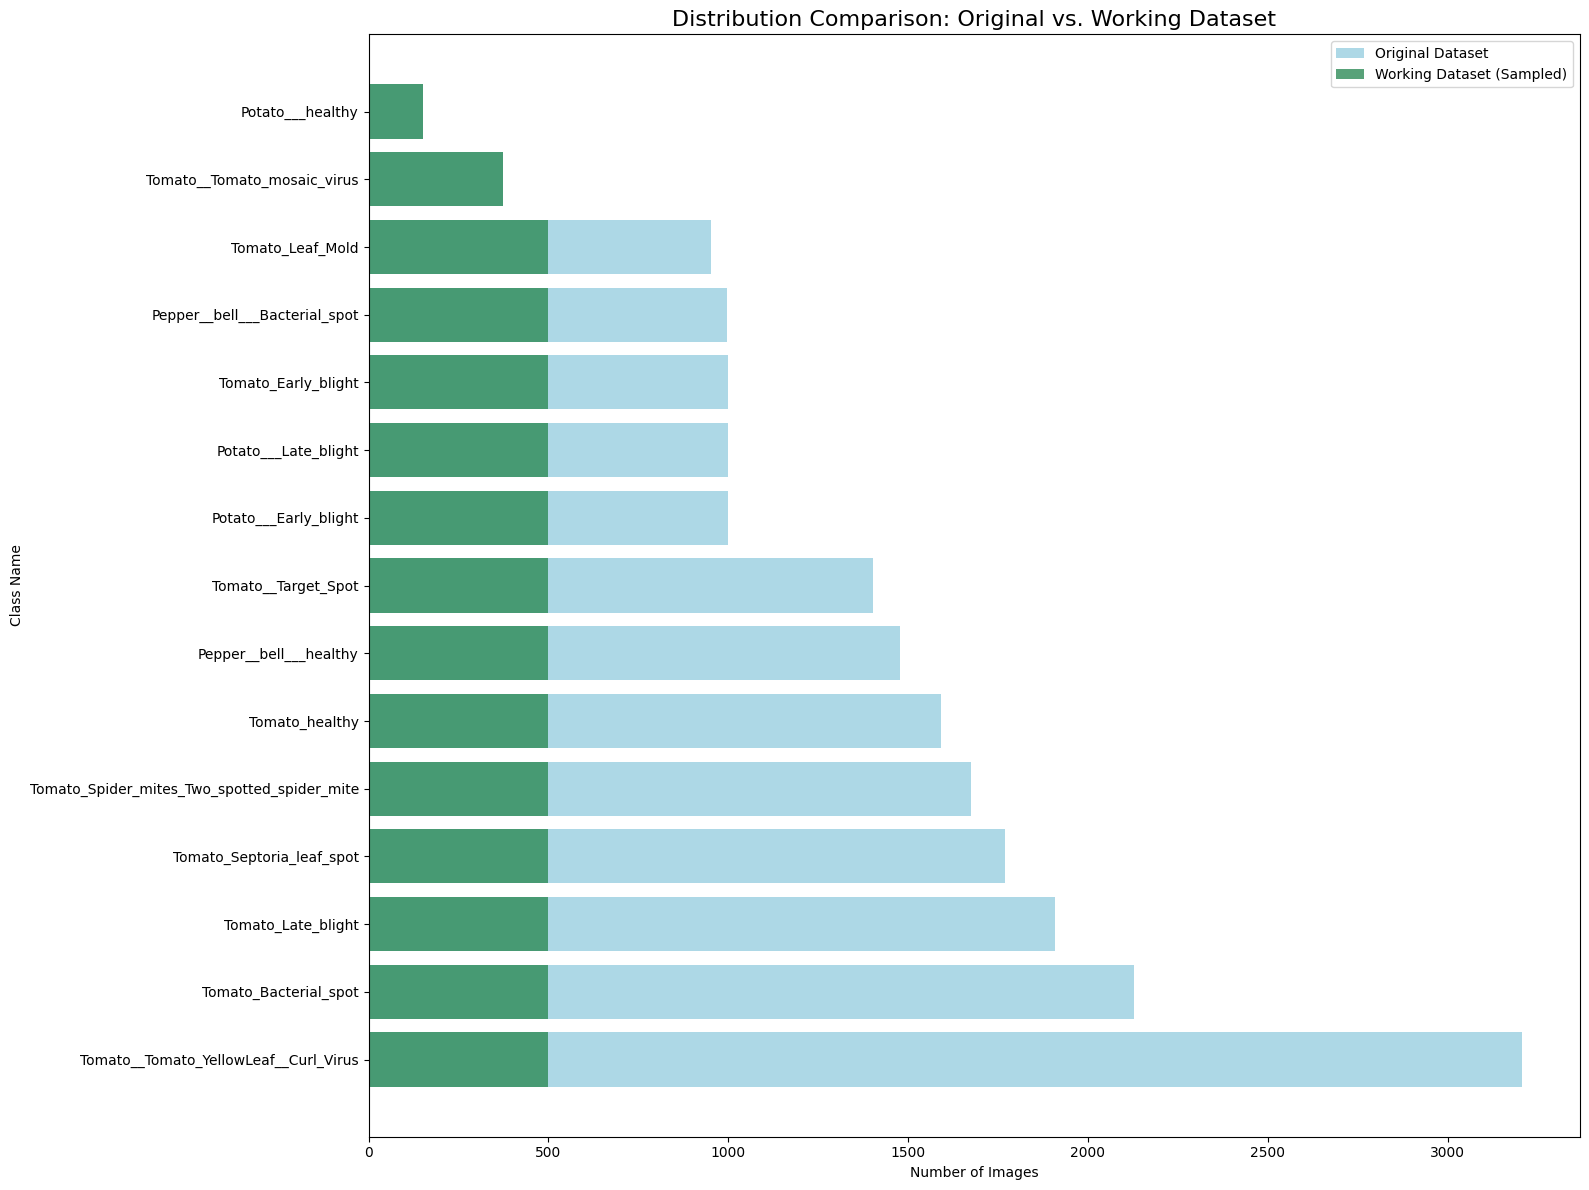

In [29]:
# ==============================================================
# 📊 Original vs Working Dataset Distribution Comparison
# ==============================================================

# 1. Compute original dataset counts
orig_counts = {}
for cls in class_folders:
    cls_path = os.path.join(RUNTIME_ORIG, cls)
    total = 0
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        total += len(glob.glob(os.path.join(cls_path, ext)))
    orig_counts[cls] = total

df_orig = pd.DataFrame(orig_counts.items(), columns=["Class", "Original_Count"])

# 2. Working dataset counts already computed as df_counts → rename for clarity
df_work = df_counts.rename(columns={"Count": "Working_Count"})

# 3. Merge comparison
df_compare = pd.merge(df_orig, df_work, on="Class")

# 4. Sort for visualization
df_compare_sorted = df_compare.sort_values("Original_Count", ascending=False)

# 5. Plot
plt.figure(figsize=(16, 12))

# Plot Original dataset
plt.barh(
    df_compare_sorted["Class"],
    df_compare_sorted["Original_Count"],
    color="lightblue",
    label="Original Dataset"
)

# Plot Working dataset
plt.barh(
    df_compare_sorted["Class"],
    df_compare_sorted["Working_Count"],
    color="seagreen",
    alpha=0.8,
    label="Working Dataset (Sampled)"
)

plt.title("Distribution Comparison: Original vs. Working Dataset", fontsize=16)
plt.xlabel("Number of Images")
plt.ylabel("Class Name")
plt.legend()
plt.tight_layout()
plt.show()


##  4. Data Preprocessing and Augmentation
We will:
- Resize images to 128×128 (standard for pre-trained models)
- Normalize pixel values
- Apply augmentation (rotation, zoom, flip, etc.)

In [ ]:
# ==============================================================
# 🚀 Reduce dataset size to speed up training
# ==============================================================

import glob
import os
import random

MAX_IMAGES_PER_CLASS = 300

for cls in classes:
    cls_path = os.path.join(data_dir, cls)

    # get all images
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        images.extend(glob.glob(os.path.join(cls_path, ext)))

    # if class has more images → reduce
    if len(images) > MAX_IMAGES_PER_CLASS:
        # shuffle and remove extra
        images_to_remove = images[MAX_IMAGES_PER_CLASS:]
        for img in images_to_remove:
            os.remove(img)

print("Dataset trimmed successfully.")


Dataset trimmed successfully.


In [ ]:
# ==============================================================
#  PREPROCESSING + IMAGE GENERATORS (Clean & Robust Version)
# ==============================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for all models (MobileNet expect 128x128)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32




In [ ]:
# ==============================================================
#  ImageDataGenerator with Augmentation for Training
# ==============================================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,     # 20% validation
    rotation_range=25,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.20,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Validation generator (NO augmentation except rescaling)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)



In [ ]:
# ==============================================================
#  Training Data
# ==============================================================

train_data = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)



Found 3482 images belonging to 15 classes.


In [ ]:
x, y = next(train_data)
print("Batch shape:", x.shape, y.shape)

Batch shape: (32, 128, 128, 3) (32, 15)


In [ ]:
# ==============================================================
#  Validation Data
# ==============================================================

valid_data = valid_datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)



Found 870 images belonging to 15 classes.


In [ ]:
# ==============================================================
#   Confirm class mapping and counts
# ==============================================================

print("\n Class Index Mapping:")
for cls, idx in train_data.class_indices.items():
    print(f"   • {cls}: {idx}")

num_classes = train_data.num_classes

print("\n Dataset Summary:")
print(f"   • Number of classes detected: {num_classes}")
print(f"   • Training Image Count: {train_data.samples}")
# print(f"   • Validation Image Count: {valid_data.samples}")



 Class Index Mapping:
   • Pepper__bell___Bacterial_spot: 0
   • Pepper__bell___healthy: 1
   • Potato___Early_blight: 2
   • Potato___Late_blight: 3
   • Potato___healthy: 4
   • Tomato_Bacterial_spot: 5
   • Tomato_Early_blight: 6
   • Tomato_Late_blight: 7
   • Tomato_Leaf_Mold: 8
   • Tomato_Septoria_leaf_spot: 9
   • Tomato_Spider_mites_Two_spotted_spider_mite: 10
   • Tomato__Target_Spot: 11
   • Tomato__Tomato_YellowLeaf__Curl_Virus: 12
   • Tomato__Tomato_mosaic_virus: 13
   • Tomato_healthy: 14

 Dataset Summary:
   • Number of classes detected: 15
   • Training Image Count: 3482



#  5. BASELINE CNN MODEL (Benchmark)


In this section, I have build a simple Convolutional Neural Network (CNN) to establish  
a baseline performance metric. This helps compare how much improvement we gain  
from Transfer Learning models like  MobileNetV2 or ResNet50.



In [ ]:
# ==============================================================
# 🧱 Build FAST Baseline CNN
# ==============================================================

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

baseline_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

baseline_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### 🔁 Training the Baseline CNN
We apply:

- **EarlyStopping**: Avoid overfitting  
- **ModelCheckpoint**: Save the best model weights  
- **Validation Monitoring**


In [ ]:
# ==============================================================
# 🎯 Train Fast Baseline CNN
# ==============================================================

callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("baseline_cnn_fast.h5", save_best_only=True)
]

history_cnn = baseline_cnn.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    callbacks=callbacks_cnn,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1111 - loss: 2.6589

109/109 ━━━━━━━━━━━━━━━━━━━━ 1328s 12s/step - accuracy: 0.1116 - loss: 2.6578 - val_accuracy: 0.3356 - val_loss: 2.1196
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2915 - loss: 2.1866

109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 0.2917 - loss: 2.1858 - val_accuracy: 0.4161 - val_loss: 1.8208
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4076 - loss: 1.8075

109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.4078 - loss: 1.8071 - val_accuracy: 0.5379 - val_loss: 1.4188
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4924 - loss: 1.5394

109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 0.4925 - loss: 1.5390 - val_accuracy: 0.5943 - val_loss: 1.2172
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5498 - loss: 1.3494

109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - accuracy: 0.5499 - loss: 1.3492 - val_accuracy: 0.6540 - val_loss: 1.0636
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 296ms/step - accuracy: 0.6083 - loss: 1.2134 - val_accuracy: 0.6598 - val_loss: 1.1200
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 0.6039 - loss: 1.1623 - val_accuracy: 0.6609 - val_loss: 1.0855
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6443 - loss: 1.0889

109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 294ms/step - accuracy: 0.6444 - loss: 1.0885 - val_accuracy: 0.7563 - val_loss: 0.7897
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 0.6754 - loss: 1.0233 - val_accuracy: 0.7345 - val_loss: 0.8835
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 296ms/step - accuracy: 0.6938 - loss: 0.9443 - val_accuracy: 0.7425 - val_loss: 0.8393
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 304ms/step - accuracy: 0.6886 - loss: 0.9318 - val_accuracy: 0.7448 - val_loss: 0.8045


##  6. Model Performance Evaluation (CNN)
Now, I'll plot training history and evaluate accuracy and confusion matrix. For context, here I plot training vs. validation accuracy and loss to assess learning behavior.

##  7. Transfer Learning with ResNet50
I have used a pre-trained **ResNet50** model to leverage existing image representations.

##  8. Results Comparison
Compare baseline CNN and Transfer Learning model.

##  9. Model Interpretability with Grad-CAM
I have now used Grad-CAM to visualize which regions of the image influence predictions most.

##  10. Conclusion and Findings

**Summary of Work:**
- Implemented two models: a custom CNN and a Transfer Learning model (ResNet50).  
- Achieved improved validation accuracy with transfer learning.  
- Used Grad-CAM for interpretability.

**Future Improvements:**
- Fine-tune more layers in ResNet50 for higher accuracy.  
- Test MobileNetV2 or EfficientNet for efficiency.  
- Deploy as a simple web app for farmers (possible extra credit task).